# Intro

In [236]:
import time
import numpy as np
import pandas as pd
import plotly.express as px
import csv
import spacy
import sqlalchemy as db 
from sqlalchemy import create_engine, types
import plotly.graph_objects as go # express does not support secondary axis
from plotly.subplots import make_subplots
from collections import Counter
from statsmodels.tsa.seasonal import STL
import re
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller, kpss
import matplotlib.pyplot as plt
import json
import openpyxl
from config import path_config, file_config, time_config

# DataSets

## Public bonds (Treasury)

####  Treasury

Rates: 
https://www.tesourotransparente.gov.br/ckan/dataset/taxas-dos-titulos-ofertados-pelo-tesouro-direto/resource/796d2059-14e9-44e3-80c9-2d9e30b405c1?_gl=1*1megsd7*_ga*MjA1MzU2NjgzMS4xNzAwODUwOTU1*_ga_95FH8RQ7M0*MTcwMDg1MDk1NS4xLjEuMTcwMDg1MTA2Ny4xMS4wLjA.

Metadata:
https://www.tesourotransparente.gov.br/ckan/dataset/df56aa42-484a-4a59-8184-7676580c81e3/resource/1a8eb2e3-4902-4a38-a1eb-6410f23d90de/download/Taxa.pdf

- Taxa_compra --> bid rate
- Taxa_venda --> ask rate

In [238]:
taxas = pd.read_csv(f'{path_config.path_economic}\{file_config.treasury_file}', sep = ';', decimal = ',',
                   parse_dates = ['Data Vencimento', 'Data Base'], dayfirst=True)
taxas.columns = ['tipo', 'data_vencimento', 'data_base', 'tx_compra_manha',
       'tx_venda_manha', 'pu_compra_manha', 'pu_venda_manha', 'pu_base_manha'] 

taxas['prazo_dias'] = (taxas['data_vencimento'] - taxas['data_base']).dt.days
taxas['prazo_meses'] = taxas['prazo_dias']/30
taxas['prazo_anos'] = taxas['prazo_dias']/365
len(taxas)

136293

In [239]:
taxas.head(1)

,tipo,data_vencimento,data_base,tx_compra_manha,tx_venda_manha,pu_compra_manha,pu_venda_manha,pu_base_manha,prazo_dias,prazo_meses,prazo_anos
0,Tesouro IGPM+ com Juros Semestrais,2011-03-01,2005-11-25,8.93,8.99,1635.96,1631.95,1630.89,1922,64.066667,5.265753


In [240]:
taxas['tipo'].value_counts()

tipo
Tesouro IPCA+ com Juros Semestrais        37611
Tesouro Prefixado                         24347
Tesouro Prefixado com Juros Semestrais    23362
Tesouro Selic                             18097
Tesouro IGPM+ com Juros Semestrais        15091
Tesouro IPCA+                             14889
Tesouro Renda+ Aposentadoria Extra         1632
Tesouro Educa+                             1264
Name: count, dtype: int64

### Prefixed

In [241]:
# cheking with the lattest rentability announced in tesouro website --> ok!
pre_fixado = taxas.loc[taxas['tipo'] == 'Tesouro Prefixado'].sort_values(by='data_base', ascending=False)
pre_fixado.head(1) 
# first check was ok, new checks must update dataset

,tipo,data_vencimento,data_base,tx_compra_manha,tx_venda_manha,pu_compra_manha,pu_venda_manha,pu_base_manha,prazo_dias,prazo_meses,prazo_anos
23498,Tesouro Prefixado,2024-07-01,2023-11-23,10.89,11.01,940.71,939.72,939.72,221,7.366667,0.605479


#### ***Long term interest rate

Very important:

This methodology will need to be detailed further later. I am filtering only the title with the longest term for each database.
The justification is that I want to capture the long term. However, the distance to the long term changes over time.

This has implications:

The rate always tends to decline over time because the same title tends to have a shorter term (= lower risk) until a new title with a longer term is issued (how to control this?).

In [242]:
pre_fixado_long = pre_fixado.loc[pre_fixado.groupby(
                    pre_fixado['data_base'].dt.date)['prazo_dias'].idxmax()].sort_values(
                        by='data_base', ascending=False)
pre_fixado_long['data_base'].nunique(), len(pre_fixado_long) # ok

(4717, 4717)

In [243]:
pre_fixado_long['prazo_meses'].describe()

count    4717.000000
mean       49.279584
std        19.675221
min        16.700000
25%        29.633333
50%        45.766667
75%        67.366667
max        84.400000
Name: prazo_meses, dtype: float64

C:\Users\Lord-\miniconda3\envs\sa-pytorch\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



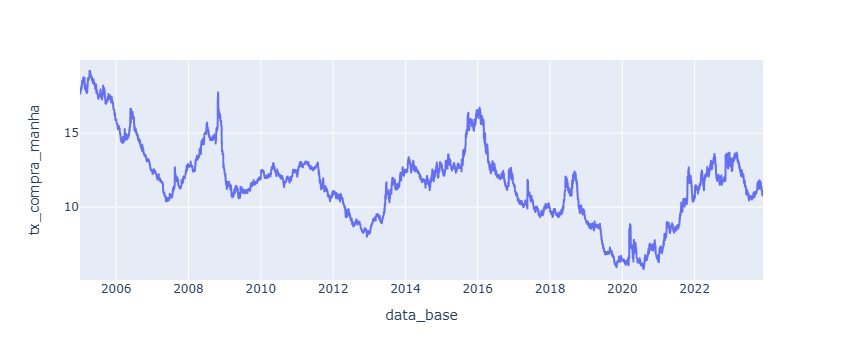

In [244]:
px.line(pre_fixado_long, x = 'data_base', y = 'tx_compra_manha')

### Issuance analysis

In [245]:
#There are few maturity dates → the issuance of fixed-rate bonds in the market is sporadic, but trading is daily and intense.
pre_fixado_long['data_vencimento'].value_counts()

data_vencimento
2023-01-01    505
2026-01-01    504
2025-01-01    499
2029-01-01    439
2018-01-01    281
2015-01-01    269
2017-01-01    260
2013-01-01    251
2009-01-01    236
2016-01-01    235
2021-01-01    221
2012-01-01    211
2010-07-01    146
2010-01-01    103
2008-07-01    100
2008-01-01     98
2011-01-01     98
2007-01-01     76
2009-10-01     64
2009-07-01     55
2007-07-01     35
2006-07-01     31
Name: count, dtype: int64

C:\Users\Lord-\miniconda3\envs\sa-pytorch\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



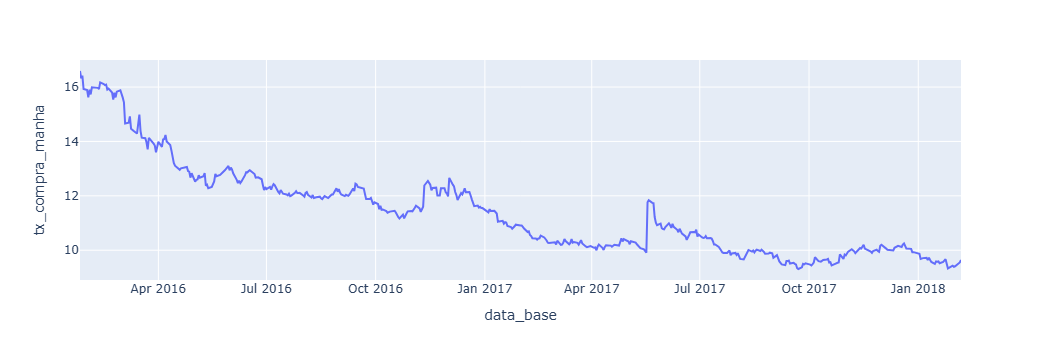

In [246]:
#Every bond will have a tendency to decay in yield as it approaches maturity. Remember that the rate is fixed, while the face value varies, altering the amount received by the final holder.
px.line(pre_fixado_long.query("data_vencimento == '2023-01-01'"), x = 'data_base', y = 'tx_compra_manha')
# But why are there dates only up to a few years before the bond's maturity?

C:\Users\Lord-\miniconda3\envs\sa-pytorch\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



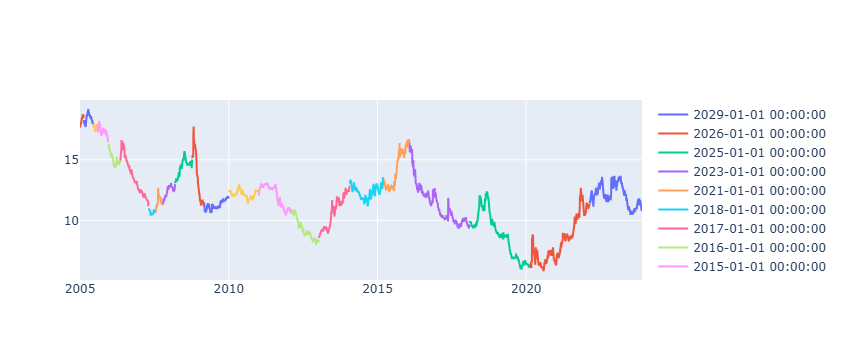

In [247]:
fig = go.Figure()
for data in pre_fixado_long['data_vencimento'].unique():
    df_data = pre_fixado_long.query(f"data_vencimento == '{data}'")
    x_data = df_data['data_base']
    y_data = df_data['tx_compra_manha']
    fig.add_trace(go.Scatter(x=x_data, y=y_data, mode='lines', name=f'{data}'))
    #px.line(, x = 'data_base', y = 'tx_compra_manha')
fig

In [248]:
pre_fixado.query("data_base == '2023-11-21'")

,tipo,data_vencimento,data_base,tx_compra_manha,tx_venda_manha,pu_compra_manha,pu_venda_manha,pu_base_manha,prazo_dias,prazo_meses,prazo_anos
23853,Tesouro Prefixado,2029-01-01,2023-11-21,10.87,10.99,591.10,587.60,587.60,1868,62.266667,5.117808
23852,Tesouro Prefixado,2024-07-01,2023-11-21,10.89,11.01,939.94,938.94,938.94,223,7.433333,0.610959
23854,Tesouro Prefixado,2026-01-01,2023-11-21,10.32,10.44,812.10,809.91,809.91,772,25.733333,2.115068
23855,Tesouro Prefixado,2025-01-01,2023-11-21,10.45,10.57,895.09,893.65,893.65,407,13.566667,1.115068


In [249]:
pre_fix = pre_fixado_long[['data_vencimento', 'data_base', 'tx_compra_manha', 'prazo_dias']]

In [250]:
pre_fix_month = pre_fix.resample('M', on='data_base', origin='end_day').mean()
pre_fix_month.index = pre_fix_month.index.to_period('M').to_timestamp('M') - pd.offsets.MonthBegin(1)
pre_fix_month.reset_index(inplace=True)
pre_fix_month.rename(columns = {'data_base': 'date_time_month',
                               'tx_compra_manha': 'prefix_media_juros',
                               'prazo_dias': 'prefix_media_prazo_dias'}, inplace=True)

In [251]:
pre_fix_month = pre_fix_month[['date_time_month', 'prefix_media_juros', 'prefix_media_prazo_dias']]

## SELIC

In [252]:
selic = pd.read_csv(f'{path_config.path_economic}\{file_config.selic_file}', sep=';', decimal = ',')
selic.columns = ['date_time_day', 'selic_meta']
selic.drop(len(selic) - 1, axis=0, inplace=True)
selic['selic_meta'] = selic['selic_meta'].str.replace(',', '.')
selic['selic_meta'] = pd.to_numeric(selic['selic_meta'])
selic['date_time_day'] = pd.to_datetime(selic['date_time_day'], format = '%d/%m/%Y')
selic = selic.resample('M', on='date_time_day', origin='end_day').mean()
selic.index = selic.index.to_period('M').to_timestamp('M') - pd.offsets.MonthBegin(1)
selic.reset_index(inplace=True)
selic.rename(columns = {'date_time_day': 'date_time_month'}, inplace=True)
selic['selic_meta'] = selic['selic_meta'].round(2)

In [253]:
selic

,date_time_month,selic_meta
0,2000-01-01,19.00
1,2000-02-01,19.00
2,2000-03-01,18.95
3,2000-04-01,18.50
4,2000-05-01,18.50
...,...,...
286,2023-11-01,12.27
287,2023-12-01,11.96
288,2024-01-01,11.75
289,2024-02-01,11.25


## Sentiment Indexes

### Strategies Analysis

In [254]:
strategies_all = pd.read_csv(f'{path_config.path_exports}\{file_config.strategies_file}')

In [255]:
len(strategies_all)

156

In [256]:
strategies_all[f'date_time_{time_config.day_month}'] = pd.to_datetime(strategies_all[f'date_time_{time_config.day_month}'])

In [257]:
strategies_all.columns

Index(['date_time_month', 'sentiment_agg_carosia_by_month_with_op',
       'sentiment_weighted_agg_carosia_by_month_with_op',
       'sentiment_agg_picault_by_month_with_op',
       'sentiment_agg_carosia_by_month_with_sentilex',
       'sentiment_weighted_agg_carosia_by_month_with_sentilex',
       'sentiment_agg_picault_by_month_with_sentilex',
       'sentiment_agg_carosia_by_month_with_lm',
       'sentiment_weighted_agg_carosia_by_month_with_lm',
       'sentiment_agg_picault_by_month_with_lm',
       'sentiment_agg_carosia_by_month_with_vader',
       'sentiment_weighted_agg_carosia_by_month_with_vader',
       'sentiment_agg_picault_by_month_with_vader',
       'normalized_sentiment_agg_carosia_by_month_with_op',
       'normalized_sentiment_weighted_agg_carosia_by_month_with_op',
       'normalized_sentiment_agg_picault_by_month_with_op',
       'normalized_sentiment_agg_carosia_by_month_with_sentilex',
       'normalized_sentiment_weighted_agg_carosia_by_month_with_sentilex',


In [258]:
# usefull columns
strategies_filt = strategies_all[[f'date_time_{time_config.day_month}',
                                'normalized_sentiment_agg_carosia_by_month_with_op',
                                'normalized_sentiment_weighted_agg_carosia_by_month_with_op',
                                'normalized_sentiment_agg_picault_by_month_with_op',
                                'normalized_sentiment_agg_carosia_by_month_with_sentilex',
                                'normalized_sentiment_weighted_agg_carosia_by_month_with_sentilex',
                                'normalized_sentiment_agg_picault_by_month_with_sentilex',
                                'normalized_sentiment_agg_carosia_by_month_with_lm',
                                'normalized_sentiment_weighted_agg_carosia_by_month_with_lm',
                                'normalized_sentiment_agg_picault_by_month_with_lm',
                                'normalized_sentiment_agg_carosia_by_month_with_vader',
                                'normalized_sentiment_weighted_agg_carosia_by_month_with_vader',
                                'normalized_sentiment_agg_picault_by_month_with_vader']]

In [259]:
strategies_filt.head()

,date_time_month,normalized_sentiment_agg_carosia_by_month_with_op,normalized_sentiment_weighted_agg_carosia_by_month_with_op,normalized_sentiment_agg_picault_by_month_with_op,normalized_sentiment_agg_carosia_by_month_with_sentilex,normalized_sentiment_weighted_agg_carosia_by_month_with_sentilex,normalized_sentiment_agg_picault_by_month_with_sentilex,normalized_sentiment_agg_carosia_by_month_with_lm,normalized_sentiment_weighted_agg_carosia_by_month_with_lm,normalized_sentiment_agg_picault_by_month_with_lm,normalized_sentiment_agg_carosia_by_month_with_vader,normalized_sentiment_weighted_agg_carosia_by_month_with_vader,normalized_sentiment_agg_picault_by_month_with_vader
0,2009-01-01,-1.8315,-1.1212,-0.6106,1.6605,1.2305,0.6775,-0.9431,-0.5427,-1.7859,-1.6204,-1.0018,-1.0128
1,2009-02-01,-0.2775,-0.1951,0.0105,2.7673,2.0067,1.7604,-1.5770,-1.0556,-1.0106,-3.2233,-2.1399,-2.0586
2,2009-03-01,-1.2222,-0.8117,-1.2628,1.2587,0.9634,0.7907,-1.2103,-0.7875,-1.2517,-1.1625,-0.7067,-0.8888
3,2009-04-01,-2.8828,-1.7337,-3.4256,-1.4958,-0.9210,-1.4379,-1.1470,-0.7324,-1.4421,-1.6454,-1.0357,-1.5767
4,2009-05-01,-0.7331,-0.5160,-0.5853,0.5167,0.4163,0.5058,-0.5758,-0.2934,-0.4929,-1.4404,-0.8517,-1.0279


### Indexes Comparisson

In [260]:
strategies_filt.columns

Index(['date_time_month', 'normalized_sentiment_agg_carosia_by_month_with_op',
       'normalized_sentiment_weighted_agg_carosia_by_month_with_op',
       'normalized_sentiment_agg_picault_by_month_with_op',
       'normalized_sentiment_agg_carosia_by_month_with_sentilex',
       'normalized_sentiment_weighted_agg_carosia_by_month_with_sentilex',
       'normalized_sentiment_agg_picault_by_month_with_sentilex',
       'normalized_sentiment_agg_carosia_by_month_with_lm',
       'normalized_sentiment_weighted_agg_carosia_by_month_with_lm',
       'normalized_sentiment_agg_picault_by_month_with_lm',
       'normalized_sentiment_agg_carosia_by_month_with_vader',
       'normalized_sentiment_weighted_agg_carosia_by_month_with_vader',
       'normalized_sentiment_agg_picault_by_month_with_vader'],
      dtype='object')

C:\Users\Lord-\miniconda3\envs\sa-pytorch\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



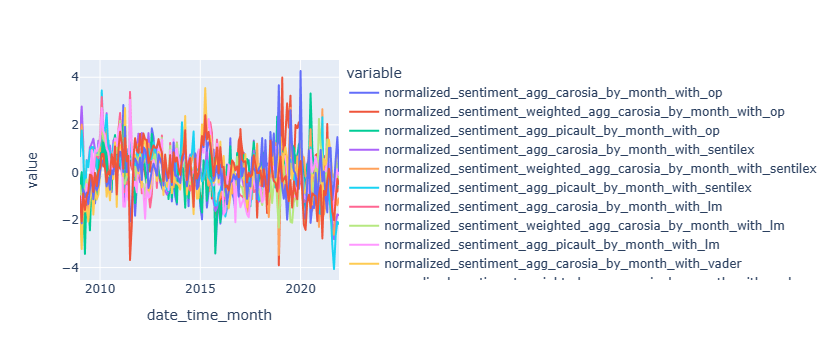

In [261]:
px.line(strategies_filt, 
        x = 'date_time_month',
        y = ['normalized_sentiment_agg_carosia_by_month_with_op',
       'normalized_sentiment_weighted_agg_carosia_by_month_with_op',
       'normalized_sentiment_agg_picault_by_month_with_op',
       'normalized_sentiment_agg_carosia_by_month_with_sentilex',
       'normalized_sentiment_weighted_agg_carosia_by_month_with_sentilex',
       'normalized_sentiment_agg_picault_by_month_with_sentilex',
       'normalized_sentiment_agg_carosia_by_month_with_lm',
       'normalized_sentiment_weighted_agg_carosia_by_month_with_lm',
       'normalized_sentiment_agg_picault_by_month_with_lm',
       'normalized_sentiment_agg_carosia_by_month_with_vader',
       'normalized_sentiment_weighted_agg_carosia_by_month_with_vader',
       'normalized_sentiment_agg_picault_by_month_with_vader'])

## Confidence indexes (Month)

Downloaded from sistema gerador de series temporais do banco central

### Consumer Confidence (ICC)

In [262]:
indice_confianca_mensal = pd.read_csv(f'{path_config.path_economic}\{file_config.confidence_file}, 
                                      sep = ';', decimal = ',')
indice_confianca_mensal.columns = ['date_time_month', 'icc', 'sond_servicos', 'sond_servicos_dessaz']
for col in ['icc', 'sond_servicos', 'sond_servicos_dessaz']:
    indice_confianca_mensal[col] = pd.to_numeric(
        indice_confianca_mensal[col].str.replace(',', '.'), errors = 'coerce')
for a, b in [('jan', 'jan'), ('fev', 'feb'), ('mar', 'mar'), ('abr', 'apr'), ('mai', 'may'), ('jun', 'jun'),
             ('jul', 'jul'), ('ago', 'aug'), ('set', 'sep'), ('out', 'oct'), ('nov', 'nov'), ('dez', 'dec')]:
    indice_confianca_mensal['date_time_month'] = indice_confianca_mensal['date_time_month'].str.replace(a,b)
indice_confianca_mensal['date_time_month'] = pd.to_datetime(indice_confianca_mensal['date_time_month'], format='%b/%y')
#indice_confianca_mensal = indice_confianca_mensal.query(F"date_time_month >= '{DATA_INICIO}' & date_time_month <= '{DATA_FIM}'")

In [263]:
indice_confianca_mensal.head(3)

,date_time_month,icc,sond_servicos,sond_servicos_dessaz
0,1999-03-01,75.72,NaN,NaN
1,1999-04-01,75.86,NaN,NaN
2,1999-05-01,77.29,NaN,NaN


C:\Users\Lord-\miniconda3\envs\sa-pytorch\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



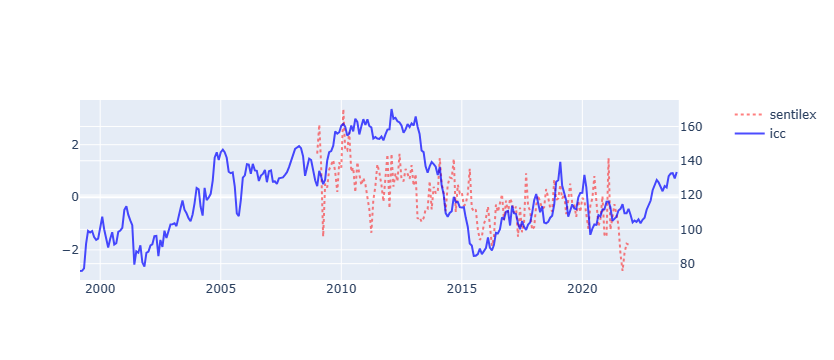

In [264]:
X_1 = strategies_filt[f'date_time_{time_config.day_month}']
Y_1 = strategies_filt['normalized_sentiment_agg_carosia_by_month_with_sentilex']
X_2 = indice_confianca_mensal['date_time_month']
Y_2 = indice_confianca_mensal['icc']
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])
# Add traces
fig.add_trace(go.Scatter(x=X_1, y=Y_1, 
                         name='sentilex',
                         line = dict(color = 'red', dash='dot'), 
                         opacity = 0.5),
                         secondary_y=False)
fig.add_trace(go.Scatter(x=X_2, y=Y_2, 
                         name="icc",  
                         line = dict(color = 'blue'),
                         opacity = 0.7),
                         secondary_y=True)

In [265]:
strategies_filt.head(2)

,date_time_month,normalized_sentiment_agg_carosia_by_month_with_op,normalized_sentiment_weighted_agg_carosia_by_month_with_op,normalized_sentiment_agg_picault_by_month_with_op,normalized_sentiment_agg_carosia_by_month_with_sentilex,normalized_sentiment_weighted_agg_carosia_by_month_with_sentilex,normalized_sentiment_agg_picault_by_month_with_sentilex,normalized_sentiment_agg_carosia_by_month_with_lm,normalized_sentiment_weighted_agg_carosia_by_month_with_lm,normalized_sentiment_agg_picault_by_month_with_lm,normalized_sentiment_agg_carosia_by_month_with_vader,normalized_sentiment_weighted_agg_carosia_by_month_with_vader,normalized_sentiment_agg_picault_by_month_with_vader
0,2009-01-01,-1.8315,-1.1212,-0.6106,1.6605,1.2305,0.6775,-0.9431,-0.5427,-1.7859,-1.6204,-1.0018,-1.0128
1,2009-02-01,-0.2775,-0.1951,0.0105,2.7673,2.0067,1.7604,-1.5770,-1.0556,-1.0106,-3.2233,-2.1399,-2.0586


## Industrial Production

In [266]:
pi = pd.read_csv(f'{path_config.path_exports}\{file_config.industrial_file}', sep = ';', header=1)
pi.drop(3, axis=0, inplace=True)
pi = pi.transpose()
pi.columns = pi.iloc[0].values
pi.reset_index(inplace=True)
pi.drop([0,1], axis=0, inplace=True)
pi.reset_index(inplace=True)
pi.drop('level_0', axis=1, inplace=True)

In [267]:
pattern_month = re.compile(r'^.{0,3}')
def get_month_abv(x):
    return re.search(pattern_month, x).group(0)
pattern_year = re.compile(r'\d+')
def get_year(x):
    return re.search(pattern_year, x).group(0)

In [268]:
pi['month'] = pi['index'].apply(get_month_abv)
pi['year'] = pi['index'].apply(get_year)
for mes, month in [('jan', '01'), ('fev', '02'), ('mar', '03'), ('abr', '04'),
                   ('mai', '05'), ('jun', '06'), ('jul', '07'), ('ago', '08'),
                   ('set', '09'), ('out', '10'), ('nov', '11'), ('dez', '12')]:
    pi['month'] = pi['month'].str.replace(mes, month)
pi['date_time_month'] = pi['month'] + '-' + pi['year']
pi['date_time_month'] = pd.to_datetime(pi['date_time_month'], format='%m-%Y')
pi.columns = ['index', 'industria_geral', 'industrias_extrativas',
       'industrias_transformacao', 'month', 'year', 'date_time_month']
pi = pi[['date_time_month', 'industria_geral', 'industrias_extrativas', 'industrias_transformacao']]

In [269]:
pi.head()

,date_time_month,industria_geral,industrias_extrativas,industrias_transformacao
0,2002-01-01,90.78479,74.61165,91.70908
1,2002-02-01,93.02441,76.4655,94.29032
2,2002-03-01,92.3677,77.63885,93.38011
3,2002-04-01,92.52555,77.72464,93.64301
4,2002-05-01,92.48604,76.48054,93.14947


## Inflation

In [270]:
ipca = pd.read_csv(f'{path_config.path_economic}\{file_config.inflation_file}', encoding = 'latin-1', sep = ';')
ipca.columns = ['date_time_month', 'ipca']
ipca.drop(len(ipca) - 1, axis=0, inplace=True)
ipca['ipca'] = ipca['ipca'].str.replace(',', '.')
ipca['ipca'] = pd.to_numeric(ipca['ipca'])
ipca['date_time_month'] = pd.to_datetime(ipca['date_time_month'], format = '%m/%Y')

In [271]:
ipca['ipca'] = ipca['ipca']/100
ipca['ipca_1'] = ipca['ipca'] + 1
# cumulative product
ipca['ipca_cumprod'] = ipca['ipca_1'].cumprod().round(2) 
# building the index --> para valores a preços presentes (ultima obs)
ipca['multiplier'] = (ipca['ipca_cumprod'].iloc[-1]/ipca['ipca_cumprod']).round(2)

In [272]:
ipca['ipca_index'] = 100

In [273]:
ipca['ipca_index'] = ipca['ipca_index']*ipca['ipca_cumprod']

In [274]:
ipca.head()

,date_time_month,ipca,ipca_1,ipca_cumprod,multiplier,ipca_index
0,2000-01-01,0.0062,1.0062,1.01,4.28,101.0
1,2000-02-01,0.0013,1.0013,1.01,4.28,101.0
2,2000-03-01,0.0022,1.0022,1.01,4.28,101.0
3,2000-04-01,0.0042,1.0042,1.01,4.28,101.0
4,2000-05-01,0.0001,1.0001,1.01,4.28,101.0


In [275]:
ipca['ipca_acum_12'] = ipca['ipca'].rolling(window=12, min_periods=1).sum()

In [276]:
ipca

,date_time_month,ipca,ipca_1,ipca_cumprod,multiplier,ipca_index,ipca_acum_12
0,2000-01-01,0.0062,1.0062,1.01,4.28,101.0,0.0062
1,2000-02-01,0.0013,1.0013,1.01,4.28,101.0,0.0075
2,2000-03-01,0.0022,1.0022,1.01,4.28,101.0,0.0097
3,2000-04-01,0.0042,1.0042,1.01,4.28,101.0,0.0139
4,2000-05-01,0.0001,1.0001,1.01,4.28,101.0,0.0140
...,...,...,...,...,...,...,...
285,2023-10-01,0.0024,1.0024,4.23,1.02,423.0,0.0472
286,2023-11-01,0.0028,1.0028,4.24,1.02,424.0,0.0459
287,2023-12-01,0.0056,1.0056,4.26,1.01,426.0,0.0453
288,2024-01-01,0.0042,1.0042,4.28,1.01,428.0,0.0442


## Ptax

In [277]:
ptax = pd.read_csv(f'{path_config.path_economic}\{file_config.ptax_file}', encoding = 'latin-1', sep = ';')
ptax.columns = ['date_time_day', 'ptax']
ptax.drop(len(ptax) - 1, axis=0, inplace=True)
ptax['ptax'] = ptax['ptax'].str.replace(',', '.')
ptax['ptax'] = pd.to_numeric(ptax['ptax'])
ptax['date_time_day'] = pd.to_datetime(ptax['date_time_day'], format = '%d/%m/%Y')

In [278]:
ptax = ptax.resample('M', on='date_time_day', origin='end_day').mean()
ptax.index = ptax.index.to_period('M').to_timestamp('M') - pd.offsets.MonthBegin(1)
ptax.reset_index(inplace=True)
ptax.rename(columns = {'date_time_day': 'date_time_month'}, inplace=True)

In [279]:
ptax.head()

,date_time_month,ptax
0,2000-01-01,1.803724
1,2000-02-01,1.775290
2,2000-03-01,1.742033
3,2000-04-01,1.768168
4,2000-05-01,1.827932


## Continuous Pnad (2012-

https://www.ibge.gov.br/estatisticas/sociais/trabalho/9171-pesquisa-nacional-por-amostra-de-domicilios-continua-mensal.html?=&t=o-que-e

The monthly indicators use information from the last three consecutive months of the survey, with a repetition of two months between one moving quarter and the next. Therefore, the monthly indicators of the Continuous PNAD do not reflect the situation of each month, but rather the situation of the moving quarter that ends each month.

In [280]:
tx_desocupacao = pd.read_csv(fr'{path_config.path_economic}\{file_config.pnad_file}',
                             encoding = 'latin-1', sep = ';')
tx_desocupacao.columns = ['mes', 'tx_desocupacao']

In [281]:
pattern = re.compile(r'-(\w+)\s')
def find_month_reference(x):
    return re.search(pattern, x).group(1)
tx_desocupacao['year'] = tx_desocupacao['mes'].apply(get_year)
tx_desocupacao['mes'] = tx_desocupacao['mes'].apply(find_month_reference)
for mes, month in [('jan', '01'), ('fev', '02'), ('mar', '03'), ('abr', '04'),
                   ('mai', '05'), ('jun', '06'), ('jul', '07'), ('ago', '08'),
                   ('set', '09'), ('out', '10'), ('nov', '11'), ('dez', '12')]:
    tx_desocupacao['mes'] = tx_desocupacao['mes'].str.replace(mes, month)
tx_desocupacao['date_time_month'] = tx_desocupacao['mes'] + '-' + tx_desocupacao['year']
tx_desocupacao['date_time_month'] = pd.to_datetime(tx_desocupacao['date_time_month'], format='%m-%Y')
tx_desocupacao = tx_desocupacao[['date_time_month', 'tx_desocupacao']]

In [282]:
tx_desocupacao.head()

,date_time_month,tx_desocupacao
0,2012-03-01,8.0
1,2012-04-01,7.8
2,2012-05-01,7.7
3,2012-06-01,7.6
4,2012-07-01,7.5


## Stock of Employment

BACEn Time Series
28763 - Stock of formal jobs - Total

In [283]:
emp = pd.read_csv(f'{path_config.path_economic}\{file_config.employment_file}', sep=';')
emp.columns = ['date_time_month', 'estoque_emprego']
emp.drop(len(emp)-1,axis=0,inplace=True)
emp['date_time_month'] = pd.to_datetime(emp['date_time_month'], format = '%m/%Y')
emp['estoque_emprego'] = emp['estoque_emprego'].str.replace('.','').str.replace(',','.').astype(float)

In [284]:
emp.tail()

,date_time_month,estoque_emprego
283,2023-08-01,43835028.0
284,2023-09-01,44040386.0
285,2023-10-01,44228795.0
286,2023-11-01,44358892.0
287,2023-12-01,43928023.0


## Ibovespa



In [285]:
ibov_1 = pd.read_csv(f'{path_config.path_economic}\{file_config.ibovespa_1_file}', encoding = 'latin-1', sep=';')
ibov_1.columns = ['month', 'year', 'ibov_index']
ibov_1['ibov_index'] = pd.to_numeric(ibov_1['ibov_index'].str.replace('.','').str.replace(',','.'))
ibov_1['month'] = ibov_1['month'].astype(str)
ibov_1['year'] = ibov_1['year'].astype(str)
ibov_1['date_time_month'] = ibov_1['year'] + '-' + ibov_1['month']
ibov_1['date_time_month'] = pd.to_datetime(ibov_1['date_time_month'])

In [286]:
ibov = pd.read_csv(f'{path_config.path_economic}\{file_config.ibovespa_2_file}', encoding = 'latin-1', sep=';')
ibov.columns = ['month', 'year', 'ibov_index']
ibov['ibov_index'] = pd.to_numeric(ibov['ibov_index'].str.replace('.','').str.replace(',','.'))
ibov['month'] = ibov['month'].astype(str)
ibov['year'] = ibov['year'].astype(str)
ibov['date_time_month'] = ibov['year'] + '-' + ibov['month']
ibov['date_time_month'] = pd.to_datetime(ibov['date_time_month'])

In [287]:
ibov_1.set_index('date_time_month', inplace=True)
ibov.set_index('date_time_month', inplace=True)

In [288]:
len(ibov_1), len(ibov)

(144, 144)

In [289]:
ibov = pd.concat([ibov_1, ibov])
len(ibov)

288

In [290]:
ibov.reset_index(inplace=True)

In [291]:
len(ibov), ibov['date_time_month'].nunique()

(288, 264)

In [292]:
ibov.drop_duplicates(subset = ['date_time_month', 'ibov_index'], inplace=True)

## Bacen Expectations

System:

https://dadosabertos.bcb.gov.br/dataset/expectativas-mercado
Go to "Monthly Market Expectations" (click).
Go to "API Access Point" and download the JSON.
Documentation:

https://olinda.bcb.gov.br/olinda/servico/Expectativas/versao/v1/documentacao
Endpoint:

https://olinda.bcb.gov.br/olinda/servico/Expectativas/versao/v1/odata/ExpectativasMercadoInflacao12Meses?$format=json&select
Calculation Base:

The calculation base for the statistics is based on the validity period of the expectations informed by the participating institutions:

0: use the most recent expectations informed by the participating institutions from the 30th day before the statistics calculation date.
1: use the most recent expectations informed by the participating institutions from the 4th business day before the statistics calculation date.

In [293]:
# Open the JSON file
with open(f"{path_config.path_economic}\{file_config.expectations_file}", 'r') as file:
    # Load the JSON data into a dictionary
    data = json.load(file)

In [294]:
data['@odata.context']

'https://was-p.bcnet.bcb.gov.br/olinda/servico/Expectativas/versao/v1/odata$metadata#ExpectativaMercadoMensais'

In [295]:
expect = pd.DataFrame(data['value'])

In [296]:
expect['Data'] = pd.to_datetime(expect['Data'], format = '%Y-%m-%d')
expect['Data_mes'] = pd.to_datetime(expect['Data'].dt.strftime('%Y-%m'))
expect['DataReferencia'] = pd.to_datetime(expect['DataReferencia'], format = '%m/%Y')
expect['DataReferencia_mes'] = pd.to_datetime(expect['DataReferencia'].dt.strftime('%Y-%m'))

In [297]:
expect.head(3)

,Indicador,Data,DataReferencia,Media,Mediana,DesvioPadrao,Minimo,Maximo,numeroRespondentes,baseCalculo,Data_mes,DataReferencia_mes
0,IPCA,2024-04-05,2026-03-01,0.3316,0.3,0.1101,0.20,0.7249,27.0,1,2024-04-01,2026-03-01
1,IPCA,2024-04-05,2026-03-01,0.3190,0.3,0.1226,0.12,0.8304,74.0,0,2024-04-01,2026-03-01
2,CÃ¢mbio,2024-04-05,2026-03-01,5.0164,5.0,0.1809,4.40,5.2800,20.0,1,2024-04-01,2026-03-01


In [298]:
expect['Indicador'].value_counts()

Indicador
IPCA                                152982
CÃ¢mbio                             115818
IGP-M                               107184
ProduÃ§Ã£o industrial                82638
INPC                                 80741
IPC-Fipe                             80479
IGP-DI                               79102
IPA-DI                               78505
IPA-M                                78373
IPCA-15                              78204
IPCA Livres                          32090
IPCA ServiÃ§os                       32080
IPCA Bens industrializados           32080
IPCA AlimentaÃ§Ã£o no domicÃ­lio     32079
IPCA Administrados                   31942
Taxa de desocupaÃ§Ã£o                23079
Selic                                12514
Name: count, dtype: int64

In [299]:
expect_ipca = expect[(expect['Indicador'] == 'IPCA') & (expect['baseCalculo'] == 0)]

In [300]:
expect_ipca.head()

,Indicador,Data,DataReferencia,Media,Mediana,DesvioPadrao,Minimo,Maximo,numeroRespondentes,baseCalculo,Data_mes,DataReferencia_mes
1,IPCA,2024-04-05,2026-03-01,0.3190,0.3000,0.1226,0.1200,0.8304,74.0,0,2024-04-01,2026-03-01
15,IPCA,2024-04-05,2026-02-01,0.5125,0.5000,0.1464,0.2000,0.8500,86.0,0,2024-04-01,2026-02-01
29,IPCA,2024-04-05,2026-01-01,0.3875,0.4000,0.0948,0.1510,0.6836,90.0,0,2024-04-01,2026-01-01
43,IPCA,2024-04-05,2025-12-01,0.4380,0.4373,0.1179,0.0192,0.8224,118.0,0,2024-04-01,2025-12-01
57,IPCA,2024-04-05,2025-11-01,0.2583,0.2500,0.0888,-0.0700,0.4743,118.0,0,2024-04-01,2025-11-01


In [301]:
tab_expect = expect_ipca.pivot_table(index = ['Data_mes', 'DataReferencia_mes'],
                                    values = 'Media',
                                    aggfunc = 'mean')
tab_expect.reset_index(inplace=True)

Below:

For each month, the average inflation expectation for all 24 subsequent months, the current month, and the previous month.

In [302]:
tab_expect[tab_expect['Data_mes'] == '2024-04-01']

,Data_mes,DataReferencia_mes,Media
5127,2024-04-01,2024-03-01,0.23624
5128,2024-04-01,2024-04-01,0.30120
5129,2024-04-01,2024-05-01,0.22088
5130,2024-04-01,2024-06-01,0.17316
5131,2024-04-01,2024-07-01,0.17052
5132,2024-04-01,2024-08-01,0.11778
5133,2024-04-01,2024-09-01,0.21204
5134,2024-04-01,2024-10-01,0.32132
5135,2024-04-01,2024-11-01,0.23614
5136,2024-04-01,2024-12-01,0.46320


In [303]:
# Calculate the difference in months
tab_expect['expect_meses'] = ((tab_expect['DataReferencia_mes'].dt.year - tab_expect['Data_mes'].dt.year) * 12
                     + (tab_expect['DataReferencia_mes'].dt.month - tab_expect['Data_mes'].dt.month))

In [304]:
tab_expect_12 = tab_expect.query("expect_meses >= 1 & expect_meses <= 12")

In [305]:
tab_expect_12[tab_expect_12['Data_mes'] == '2024-04-01']

,Data_mes,DataReferencia_mes,Media,expect_meses
5129,2024-04-01,2024-05-01,0.22088,1
5130,2024-04-01,2024-06-01,0.17316,2
5131,2024-04-01,2024-07-01,0.17052,3
5132,2024-04-01,2024-08-01,0.11778,4
5133,2024-04-01,2024-09-01,0.21204,5
5134,2024-04-01,2024-10-01,0.32132,6
5135,2024-04-01,2024-11-01,0.23614,7
5136,2024-04-01,2024-12-01,0.46320,8
5137,2024-04-01,2025-01-01,0.39480,9
5138,2024-04-01,2025-02-01,0.50610,10


In [306]:
# Accumulated inflation
tab_expect_12_acum = tab_expect_12.pivot_table(index = 'Data_mes',
                                              values='Media',
                                              aggfunc = 'sum')
tab_expect_12_acum.reset_index(inplace=True)

C:\Users\Lord-\miniconda3\envs\sa-pytorch\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



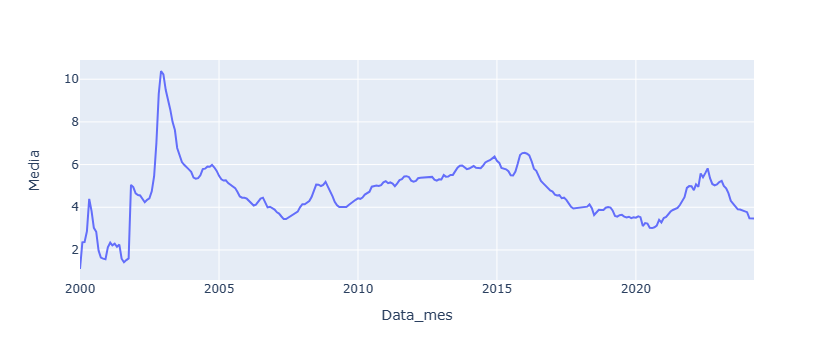

In [307]:
px.line(tab_expect_12_acum, x = 'Data_mes', y = 'Media')

In [308]:
tab_expect_12_acum.columns = ['date_time_month', 'expectativa_ipca_12']

In [309]:
tab_expect_12_acum.head(3)

,date_time_month,expectativa_ipca_12
0,2000-01-01,1.106667
1,2000-02-01,2.357238
2,2000-03-01,2.366667


## VIX

yahoo finance:
- https://finance.yahoo.com/quote/%5EVIX/history?frequency=1mo


cboe (source):
- https://www.cboe.com/tradable_products/vix/vix_historical_data/

In [310]:
vix_yahoo = pd.read_csv(fr"{path_config.path_economic}\{file_config.finance_file}")
vix_cboe = pd.read_csv(fr"{path_config.path_economic}\{file_config.cboe_file}")

In [311]:
vix_cboe.columns = vix_cboe.columns.str.lower()

In [312]:
vix_cboe['date'] = pd.to_datetime(vix_cboe['date'])

In [313]:
vix_cboe['date_time_month'] = pd.to_datetime(vix_cboe['date'].dt.strftime('%Y/%m'))

C:\Users\Lord-\AppData\Local\Temp\ipykernel_12508\1947833284.py:1: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [314]:
tab_vix = vix_cboe.pivot_table(index='date_time_month', 
                               values = 'close',
                               aggfunc='mean')
tab_vix.reset_index(inplace=True)

In [315]:
tab_vix.columns = ['date_time_month', 'vix_mean_close']

C:\Users\Lord-\miniconda3\envs\sa-pytorch\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



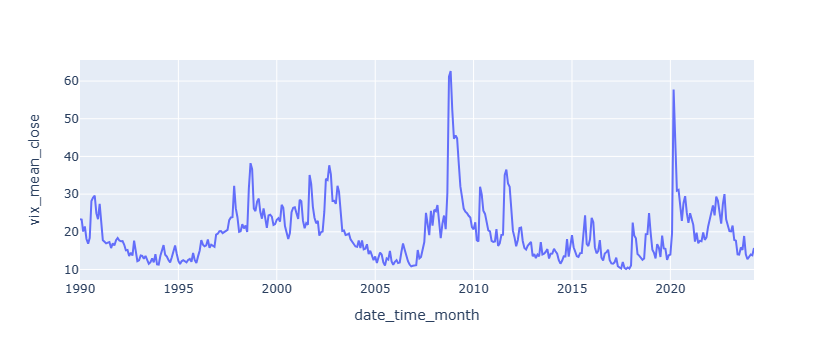

In [316]:
px.line(tab_vix, x = 'date_time_month', y = 'vix_mean_close')

## EMBI+

In [317]:
ebmi = pd.read_csv(fr"{path_config.path_economic}\{file_config.embi_file}")
ebmi.columns = ['data', 'embi_brasil', 'unnamed']
ebmi['data'] = pd.to_datetime(ebmi['data'], format = '%d/%m/%Y')
ebmi['date_time_month'] = pd.to_datetime(ebmi['data'].dt.strftime('%Y/%m'))

C:\Users\Lord-\AppData\Local\Temp\ipykernel_12508\524404588.py:4: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [318]:
tab_ebmi = ebmi.pivot_table(index='date_time_month',
                            values='embi_brasil',
                            aggfunc='mean')
tab_ebmi.reset_index(inplace=True)

In [319]:
tab_ebmi.head()

,date_time_month,embi_brasil
0,1994-04-01,1120.000000
1,1994-05-01,1146.285714
2,1994-06-01,1106.318182
3,1994-07-01,1114.300000
4,1994-08-01,916.043478


In [320]:
tab_ebmi.tail()

,date_time_month,embi_brasil
356,2023-12-01,194.500000
357,2024-01-01,200.666667
358,2024-02-01,209.700000
359,2024-03-01,207.300000
360,2024-04-01,209.363636


C:\Users\Lord-\miniconda3\envs\sa-pytorch\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



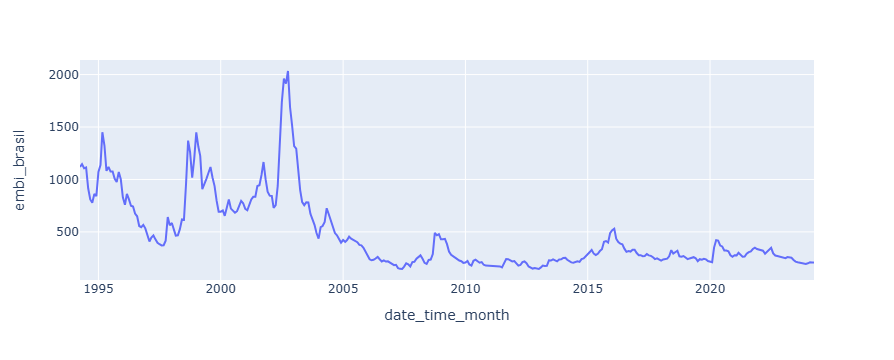

In [321]:
px.line(tab_ebmi, x = 'date_time_month', y = 'embi_brasil')

## FBCF

https://www.ipea.gov.br/cartadeconjuntura/index.php/2024/03/indicador-ipea-mensal-de-fbcf-resultado-de-janeiro-de-2023/

In [322]:
fbcf = pd.read_excel(fr"{path_config.path_economic}\{file_config.fbcf_file}",
                    sheet_name = 'Dados', header = 1)

In [323]:
fbcf.columns = ['date_time_month',
                'const_civil',
                'cons_apar_maq_e_equip',
                'cons_apar_outros',
                'indic_ipea_fbcf',
                'const_civil_aj_saz', # ajustes sazonais
                'cons_apar_maq_e_equip_aj_saz',
                'cons_apar_outros_aj_saz',
                'indic_ipea_fbcf_aj_saz']

In [324]:
fbcf.head()

,date_time_month,const_civil,cons_apar_maq_e_equip,cons_apar_outros,indic_ipea_fbcf,const_civil_aj_saz,cons_apar_maq_e_equip_aj_saz,cons_apar_outros_aj_saz,indic_ipea_fbcf_aj_saz
0,1996-01-01,82.346951,69.142303,74.010515,83.144497,87.410456,75.372458,79.297748,91.733490
1,1996-02-01,85.262721,76.582278,78.745682,92.812772,90.402027,79.744351,85.046862,97.325585
2,1996-03-01,92.053905,88.467120,89.075617,102.776013,94.577927,84.347538,89.740433,101.461122
3,1996-04-01,97.103522,91.474157,86.600553,99.445347,99.685468,91.009452,93.740399,98.804547
4,1996-05-01,103.430480,103.827235,93.415005,103.155544,102.647465,96.072170,95.057040,97.291678


In [325]:
fbcf = fbcf[['date_time_month', 'indic_ipea_fbcf']]

C:\Users\Lord-\miniconda3\envs\sa-pytorch\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



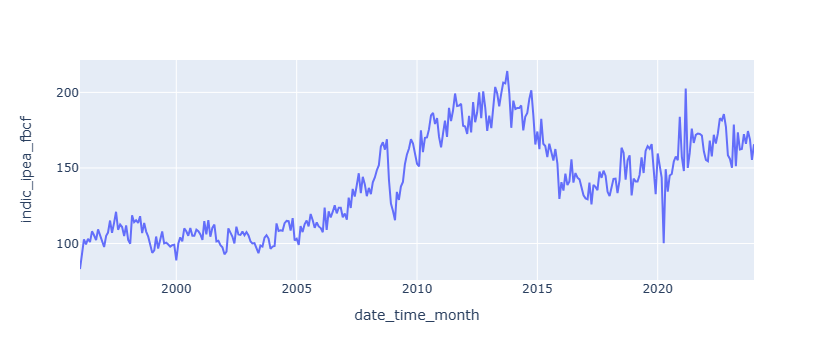

In [326]:
px.line(fbcf, x = 'date_time_month', y = 'indic_ipea_fbcf')

## IBC-BR

In [327]:
ibc_br = pd.read_csv(fr"{path_config.path_economic}\{file_config.ibc_file}", sep = ';', encoding = 'latin-1')
ibc_br.columns = ['date_time_month', 'ibc_br']
ibc_br.drop(len(ibc_br)-1, inplace=True)
ibc_br['date_time_month'] = pd.to_datetime(ibc_br['date_time_month'], format = '%m/%Y')
ibc_br['ibc_br'] = ibc_br['ibc_br'].str.replace(',','.').astype(float)

In [328]:
ibc_br.head()

,date_time_month,ibc_br
0,2003-01-01,96.15
1,2003-02-01,98.67
2,2003-03-01,103.41
3,2003-04-01,102.19
4,2003-05-01,100.30


C:\Users\Lord-\miniconda3\envs\sa-pytorch\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



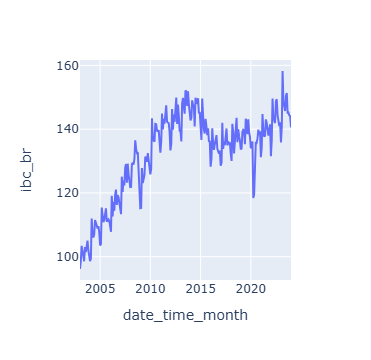

In [329]:
px.line(ibc_br, x = 'date_time_month', y = 'ibc_br')

# Merges

## Sentiment index

In [330]:
len(strategies_filt)

156

In [331]:
month_indicators_all = strategies_filt.copy()

In [332]:
month_indicators_all.head(3)

,date_time_month,normalized_sentiment_agg_carosia_by_month_with_op,normalized_sentiment_weighted_agg_carosia_by_month_with_op,normalized_sentiment_agg_picault_by_month_with_op,normalized_sentiment_agg_carosia_by_month_with_sentilex,normalized_sentiment_weighted_agg_carosia_by_month_with_sentilex,normalized_sentiment_agg_picault_by_month_with_sentilex,normalized_sentiment_agg_carosia_by_month_with_lm,normalized_sentiment_weighted_agg_carosia_by_month_with_lm,normalized_sentiment_agg_picault_by_month_with_lm,normalized_sentiment_agg_carosia_by_month_with_vader,normalized_sentiment_weighted_agg_carosia_by_month_with_vader,normalized_sentiment_agg_picault_by_month_with_vader
0,2009-01-01,-1.8315,-1.1212,-0.6106,1.6605,1.2305,0.6775,-0.9431,-0.5427,-1.7859,-1.6204,-1.0018,-1.0128
1,2009-02-01,-0.2775,-0.1951,0.0105,2.7673,2.0067,1.7604,-1.5770,-1.0556,-1.0106,-3.2233,-2.1399,-2.0586
2,2009-03-01,-1.2222,-0.8117,-1.2628,1.2587,0.9634,0.7907,-1.2103,-0.7875,-1.2517,-1.1625,-0.7067,-0.8888


## Public bonds

In [333]:
len(pre_fix_month) #2005-2023

228

In [334]:
month_indicators_all = month_indicators_all.merge(pre_fix_month,
                                                   how='left', 
                                                   on = 'date_time_month')

In [335]:
len(month_indicators_all)

156

## Selic

In [336]:
month_indicators_all = month_indicators_all.merge(selic,
                                                   how='left',
                                                   on = 'date_time_month') 
len(month_indicators_all)

156

## Trust index

In [337]:
month_indicators_all = month_indicators_all.merge(indice_confianca_mensal,
                                                   how='left',
                                                   on = 'date_time_month') 
len(month_indicators_all)

156

## Industrial production

In [338]:
month_indicators_all = month_indicators_all.merge(pi,
                                                   how='left',
                                                   on = 'date_time_month') 
len(month_indicators_all)

156

## Inflation

In [339]:
month_indicators_all = month_indicators_all.merge(ipca[['date_time_month', 'ipca', 'ipca_index', 'ipca_acum_12']],
                                                   how='left',
                                                   on = 'date_time_month') 
len(month_indicators_all)

156

## Exchange

In [340]:
month_indicators_all = month_indicators_all.merge(ptax,
                                                   how='left',
                                                   on = 'date_time_month') 
len(month_indicators_all)

156

## Occupation

In [341]:
month_indicators_all = month_indicators_all.merge(tx_desocupacao,
                                                   how='left',
                                                   on = 'date_time_month')
len(month_indicators_all)

156

## Stock of employment

In [342]:
month_indicators_all = month_indicators_all.merge(emp,
                                                   how='left',
                                                   on = 'date_time_month')
len(month_indicators_all)

156

## Ibov

In [343]:
len(ibov)

264

In [344]:
ibov['date_time_month'].nunique()

264

In [345]:
month_indicators_all = month_indicators_all.merge(ibov[['date_time_month', 'ibov_index']],
                                                   how='left',
                                                   on = 'date_time_month')
len(month_indicators_all)

156

## Expect IPCA

In [346]:
month_indicators_all = month_indicators_all.merge(tab_expect_12_acum,
                                                   how='left',
                                                   on = 'date_time_month')
len(month_indicators_all)

156

## VIX

In [347]:
month_indicators_all = month_indicators_all.merge(tab_vix,
                                                   how='left',
                                                   on = 'date_time_month')
len(month_indicators_all)

156

## EMBI

In [348]:
month_indicators_all = month_indicators_all.merge(tab_ebmi,
                                                   how='left',
                                                   on = 'date_time_month')
len(month_indicators_all)

156

## FBCF

In [349]:
month_indicators_all = month_indicators_all.merge(fbcf,
                                                   how='left',
                                                   on = 'date_time_month')
len(month_indicators_all)

156

## IBC-BR

In [350]:
month_indicators_all = month_indicators_all.merge(ibc_br,
                                                   how='left',
                                                   on = 'date_time_month')
len(month_indicators_all)

156

In [351]:
month_indicators_all.head(2)

,date_time_month,normalized_sentiment_agg_carosia_by_month_with_op,normalized_sentiment_weighted_agg_carosia_by_month_with_op,normalized_sentiment_agg_picault_by_month_with_op,normalized_sentiment_agg_carosia_by_month_with_sentilex,normalized_sentiment_weighted_agg_carosia_by_month_with_sentilex,normalized_sentiment_agg_picault_by_month_with_sentilex,normalized_sentiment_agg_carosia_by_month_with_lm,normalized_sentiment_weighted_agg_carosia_by_month_with_lm,normalized_sentiment_agg_picault_by_month_with_lm,...,ipca_acum_12,ptax,tx_desocupacao,estoque_emprego,ibov_index,expectativa_ipca_12,vix_mean_close,embi_brasil,indic_ipea_fbcf,ibc_br
0,2009-01-01,-1.8315,-1.1212,-0.6106,1.6605,1.2305,0.6775,-0.9431,-0.5427,-1.7859,...,0.0569,2.307443,NaN,30472986.0,39300.79,4.754286,44.683000,429.333333,121.504805,115.20
1,2009-02-01,-0.2775,-0.1951,0.0105,2.7673,2.0067,1.7604,-1.5770,-1.0556,-1.0106,...,0.0575,2.312672,NaN,30520793.0,38183.31,4.513889,45.570526,429.200000,115.456128,115.26


In [352]:
month_indicators_all.columns

Index(['date_time_month', 'normalized_sentiment_agg_carosia_by_month_with_op',
       'normalized_sentiment_weighted_agg_carosia_by_month_with_op',
       'normalized_sentiment_agg_picault_by_month_with_op',
       'normalized_sentiment_agg_carosia_by_month_with_sentilex',
       'normalized_sentiment_weighted_agg_carosia_by_month_with_sentilex',
       'normalized_sentiment_agg_picault_by_month_with_sentilex',
       'normalized_sentiment_agg_carosia_by_month_with_lm',
       'normalized_sentiment_weighted_agg_carosia_by_month_with_lm',
       'normalized_sentiment_agg_picault_by_month_with_lm',
       'normalized_sentiment_agg_carosia_by_month_with_vader',
       'normalized_sentiment_weighted_agg_carosia_by_month_with_vader',
       'normalized_sentiment_agg_picault_by_month_with_vader',
       'prefix_media_juros', 'prefix_media_prazo_dias', 'selic_meta', 'icc',
       'sond_servicos', 'sond_servicos_dessaz', 'industria_geral',
       'industrias_extrativas', 'industrias_transforma

# Export

In [353]:
month_indicators_all.to_csv(f'{path_config.path_exports}\{file_config.indicators_file}', index=False)